<a href="https://colab.research.google.com/github/YanaGlad/GradientDescent/blob/master/GradDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def numerical_derivative_1d(func, epsilon):
    def deriv_func(x):
        return (func(x + epsilon) - func(x)) / epsilon
    return deriv_func

In [ ]:
def polynom_to_prime(x):
    return 20 * x**5 + x**3 - 5 * x**2 + 2 * x + 2.0


def primed_poly(x):
    return 100 * x**4 + 3 * x**2 -10 * x + 2.0


approx_deriv = numerical_derivative_1d(polynom_to_prime, 1e-5)

grid = np.linspace(-2, 2, 100)
right_flag = True
tol = 0.05
debug_print = []

for x in grid:
    estimation_error = abs(primed_poly(x) - approx_deriv(x)) 
    if estimation_error > tol:
        debug_print.append((estimation_error, primed_poly(x), approx_deriv(x)))
        right_flag = False

if not right_flag:
    print(debug_print)
    plt.plot(grid, primed_poly(grid), label="Real deriv")
    plt.plot(grid, approx_deriv(grid), label="Number approximate")
    plt.legend()

print(str(right_flag))

True


In [ ]:
def grad_descent_v1(func, deriv, start=None, callback=None):
    if start is None:
        np.random.seed(179)
        start = np.random.randn()

    lr = 1e-3
    epsilon = 1e-5

    estimate = start
    while deriv(estimate) > epsilon:
        estimate -= lr * deriv(estimate)
        callback(estimate, func(estimate))

    return estimate

In [ ]:
#plt viewing steps of grad desc
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i], 
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i], 
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

#Logs
class LoggingCallback:
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

#Check 1d convergence
def test_convergence_1d(grad_descent, test_cases, tol=1e-2, axes=None, grid=None):
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):

        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]

        callback = LoggingCallback()  
        res_point = grad_descent(**test_input, callback=callback)

        # View results
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            x_steps = np.array(callback.x_steps)
            y_steps = np.array(callback.y_steps)
            plot_convergence_1d(
                test_input["func"], x_steps, y_steps, 
                ax, grid, key
            )
            ax.axvline(answer, 0, linestyle="--", c="red",
                        label=f"true answer = {answer}")
            ax.axvline(x_steps[-1], 0, linestyle="--", c="xkcd:tangerine", 
                        label=f"estimate = {np.round(x_steps[-1], 3)}")
            ax.legend(fontsize=16)

        #If point wich is found is close enough to the real one
        if abs(answer - res_point) > tol or np.isnan(res_point):
            debug_log.append(
                f"Test '{key}':\n"
                f"\t- answer: {answer}\n"
                f"\t- output: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log

IndexError: ignored

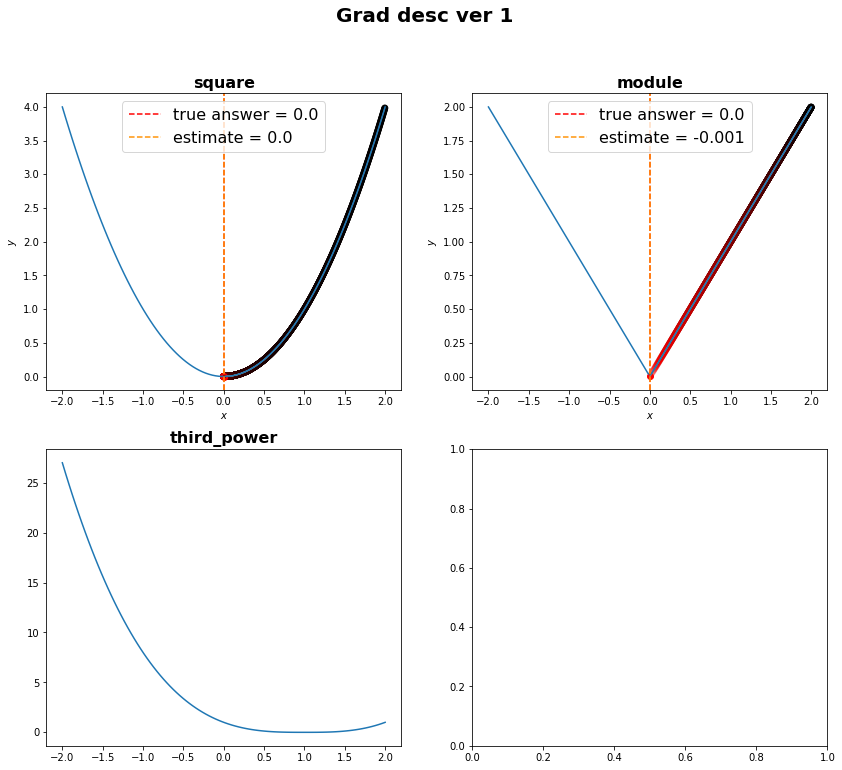

In [ ]:
test_cases = {
    "square": {
        "func" : lambda x: x * x, 
        "deriv" : lambda x: 2 * x, 
        "start" : 2, 
        "answer" : 0.0
    },
    "module": {
        "func" : lambda x: abs(x),  
        "deriv" : lambda x: 1 if x > 0 else -1,
        "start" : 2, 
        "answer" : 0.0
    },
    "third_power": {
        "func" : lambda x: abs((x - 1)**3),
        "deriv" : lambda x: 3 * (x - 1)**2 * np.sign(x-1),
        "start" : -1, 
        "answer" : 1.0
    },
    "ln_x2_1": {
        "func" : lambda x: np.log((x + 1)**2 + 1),  
        "deriv" : lambda x: 2 * (x + 1) / (x**2 +1), 
        "start" : 1, 
        "answer" : -1.0
    }
}



tol = 1e-2   
fig, axes = plt.subplots(2,2, figsize=(14, 12))
fig.suptitle("Grad desc ver 1", fontweight="bold", fontsize=20)
grid = np.linspace(-2, 2, 100)

is_correct, debug_log = test_convergence_1d(
    grad_descent_v1, test_cases, tol, 
    axes, grid
)
if not is_correct:
    for log_entry in debug_log:
        print(log_entry)

In [ ]:
def grad_descent_v2(func, deriv, low=None, high=None, callback=None):
    if low is None:
        low = -4
    if high is None:
        high = 4

    N = 30000
    eps = 0.002

    best_estimate = low

    for estimate in range(low, high):
        for i in range(N):
            estimate_last = estimate
            estimate -= eps * deriv(estimate)
            callback(estimate, func(estimate))
            if abs(estimate_last - estimate) < eps ** 2:
                break
            if func(best_estimate) > func(estimate):
                best_estimate = estimate

    return best_estimate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


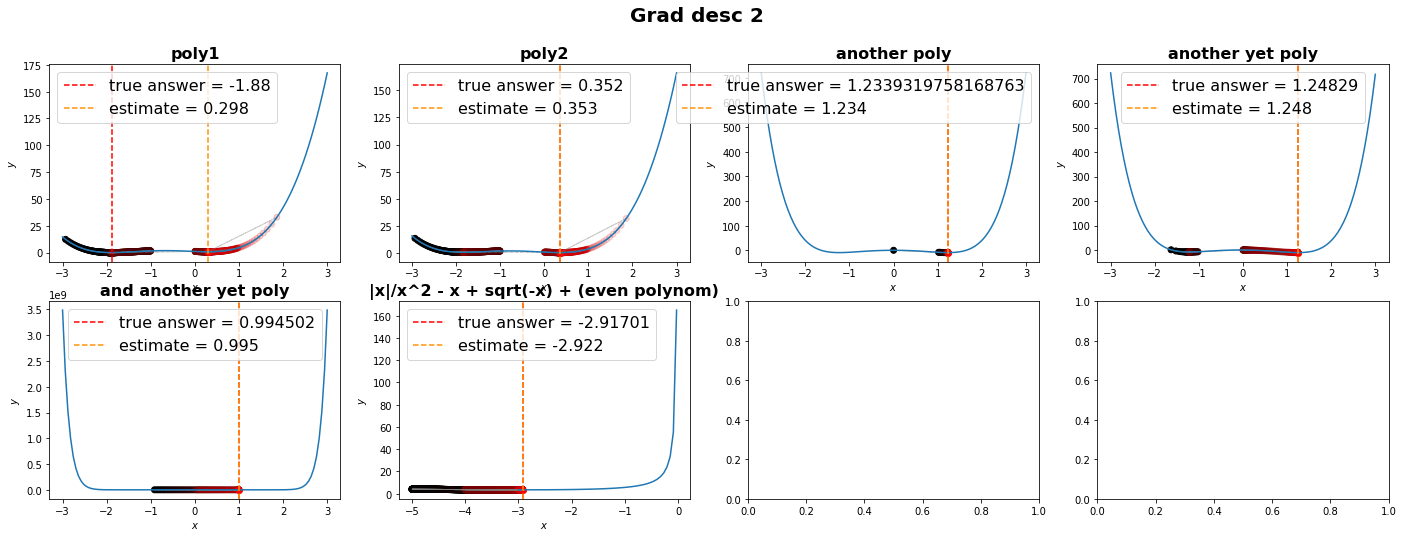

In [ ]:
test_cases = {
    "poly1" : {
        "func" : lambda x: x**4 + 3 * x**3 + x**2 - 1.5 * x + 1,
        "deriv" : lambda x: 4 * x**3 + 9 * x**2 + 2 * x - 1.5,
        "low" : -3, "high" : 3, "answer" : -1.88
    },
    "poly2" : {
        "func" : lambda x: x**4 + 3 * x**3 + x**2 - 2 * x + 1.0,
        "deriv" : lambda x: 4 * x**3 + 9 * x**2 + 2 * x - 2.0, 
        "low" : -3, "high" : 3, "answer" : 0.352
    },
    "another poly" : {
        "func" : lambda x: x**6 + x**4 - 10 * x**2 ,
        "deriv" : lambda x: 6 * x**5 + 4 * x**3 - 20 * x, 
        "low" : 0, "high" : 2, "answer" : 1/3 * np.sqrt((np.sqrt(31) - 1) * 3)
    },
    "another yet poly" : {
        "func" : lambda x: x**6 + x**4 - 10 * x**2 - x ,
        "deriv" : lambda x: 6 * x**5 + 4 * x**3 - 20 * x - 1, 
        "low" : -2, "high" : 2, "answer" : 1.24829
    },
    "and another yet poly" : {
        "func" : lambda x: x**20 + x**2 - 20 * x + 10  ,
        "deriv" : lambda x: 20 * x**19 + 2 * x - 20, 
        "low" : -1, "high" : 2, "answer" : 0.994502
    },
    "|x|/x^2 - x + sqrt(-x) + (even polynom)" : {
        "func" : lambda x: 5 * np.abs(x)/x**2 - 0.5 * x + 0.1 * np.sqrt(-x) + 0.01 * x**2 ,
        "deriv" : lambda x: -0.5 - 0.05/np.sqrt(-x) + 0.02 * x + 5/(x * np.abs(x)) - (10 * np.abs(x))/x**3,
        "low" : -5, "high" : -2, "answer" : -2.91701
    },
}

lr = 1e-2 

fig, axes = plt.subplots(2,4, figsize=(24, 8))
fig.suptitle("Grad desc 2", fontweight="bold", fontsize=20)
grid = np.linspace(-3, 3, 100)

is_correct, debug_log = test_convergence_1d(
    grad_descent_v2, test_cases, lr, 
    axes, grid
)

if not is_correct:
    for log_entry in debug_log:
        print(log_entry)

In [ ]:
#2d plt steps checking
def plot_convergence_2d(func, steps, ax, xlim, ylim, cmap="viridis", title=""):
 
    ax.set_title(title, fontsize=20, fontweight="bold")

    xrange = np.linspace(*xlim, 100)
    yrange = np.linspace(*ylim, 100)
    grid = np.meshgrid(xrange, yrange)
    X, Y = grid

    fvalues = func(
        np.dstack(grid).reshape(-1, 2)
    ).reshape((xrange.size, yrange.size))
    ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)
    CS = ax.contour(xrange, yrange, fvalues)
    ax.clabel(CS, CS.levels, inline=True)

    arrow_kwargs = dict(linestyle="--", color="black", alpha=0.8)
    for i, _ in enumerate(steps):
        if i + 1 < len(steps):
            ax.arrow(
                *steps[i],
                *(steps[i+1] - steps[i]),
                **arrow_kwargs
            )
    #Points
    n = len(steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(steps[:, 0], steps[:, 1], c=color_list, zorder=10)
    ax.scatter(steps[-1, 0], steps[-1, 1], 
               color="red", label=f"estimate = {np.round(steps[-1], 2)}")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.legend(fontsize=16)

In [ ]:
#2d view
def test_convergence_2d(grad_descent_2d, test_cases, tol, axes=None):
  
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):

        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]

        callback = LoggingCallback()  
        res_point = grad_descent_2d(**test_input, callback=callback)


        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            plot_convergence_2d(
                np.vectorize(test_input["func"], signature="(n)->()"), 
                np.vstack(callback.x_steps), 
                ax=ax, 
                xlim=(test_input["low"], test_input["high"]), 
                ylim=(test_input["low"], test_input["high"]),
                title=key
            )   

        if np.linalg.norm(answer - res_point, ord=1) > tol:
            debug_log.append(
                f"Test '{key}':\n"
                f"\t- answer: {answer}\n"
                f"\t- output: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log

Test 'concentric_circles':
	- answer: [1.  1.5]
	- output: [1.2525821 1.6262804]


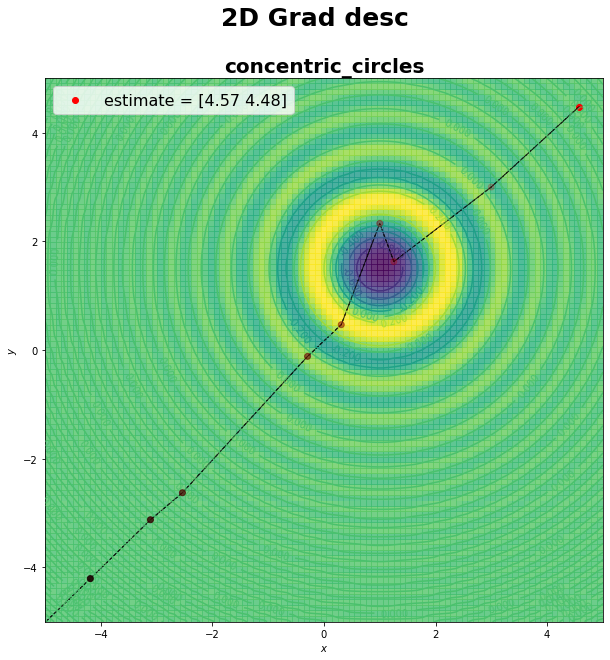

In [ ]:
test_cases = {
    "concentric_circles" : {
        "func" : lambda x: (
            -1 / ((x[0] - 1)**2 + (x[1] - 1.5)**2 + 1)
            * np.cos(2 * (x[0] - 1)**2 + 2 * (x[1] - 1.5)**2)
        ),
        "low" : -5,
        "high" : 5,
        "answer" : np.array([1, 1.5])
    }
}
lr = 1e-3   

fig, axes = plt.subplots(figsize=(10, 10), squeeze=False)
fig.suptitle("2D Grad desc", fontsize=25, fontweight="bold")
is_correct, debug_log = test_convergence_2d(grad_descent_2d, test_cases, lr, axes)

if not is_correct:
    for log_entry in debug_log:
        print(log_entry)